In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
from decimal import Decimal 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import warnings
import scipy.stats as scs
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("~/Desktop/PyWork/Data/EURUSD.csv")
data = df.copy()
data["Return"] =  np.log(data["Adj Close"]).diff()
data.dropna(axis = 0, inplace  = True)
data.set_index("Date",inplace = True)
data.head()

,High,Low,Open,Close,Volume,Adj Close,Return
Date,,,,,,,
2013-01-01,1.322401,1.319592,1.320132,1.320132,0.0,1.320132,-0.001995
2013-01-02,1.329805,1.319435,1.319784,1.319784,0.0,1.319784,-0.000264
2013-01-03,1.318913,1.308900,1.318392,1.318218,0.0,1.318218,-0.001187
2013-01-04,1.306380,1.300052,1.303101,1.303271,0.0,1.303271,-0.011403
2013-01-07,1.309929,1.302060,1.306848,1.306745,0.0,1.306745,0.002662


### Check Autocorrelation 
下圖顯示lag1~lag5的autocorrelation，結果顯示autocorrelation介於0.25與-0.25之間，也就是每日報酬與自身的lag相關性不大，不會影響模型建立

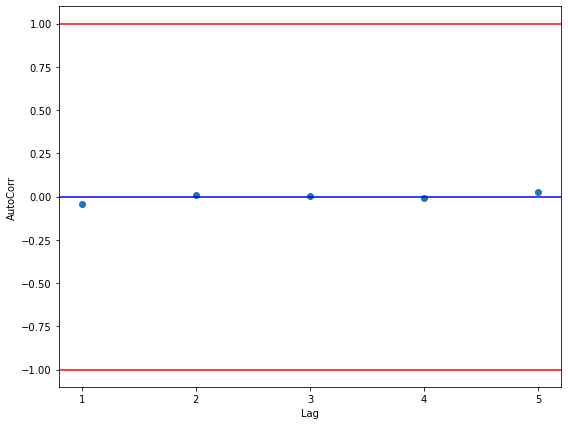

In [3]:
def acutcor(lag):
    AutoCorr = []
    for i in range(1, lag + 1):
        temp = data["Return"].autocorr(lag = i)        
        AutoCorr.append(temp)
    AutoCorr = pd.Series(AutoCorr)
    x = np.arange(1, lag + 1)
    plt.figure(figsize = (9,7))
    plt.scatter(x,AutoCorr)
    plt.xlabel("Lag")
    plt.xticks(x)
    plt.ylabel("AutoCorr")
    plt.axhline(1.0, color = "r")
    plt.axhline(0.0, color = "b")
    plt.axhline(-1.0, color = "r")
    plt.show()

lag = 5
acutcor(lag)

### Check Stationarity of return 
確認每日報酬是否為stationary，如果time series data並非stationary，會影時間序列預測準確度，下列顯示P-value小於0.5，所以拒絕null hypothesis(資料非stationary)

In [4]:
def Stationarity(data):
    Pvalue = adfuller(data,autolag='AIC')[1]
    #print("Pvalue from ADF test =",Decimal(Pvalue).quantize(Decimal('.000000001'), rounding="ROUND_DOWN"))
    if Pvalue < 0.5:
        print("Time series data is stationary.")
    else:
        print("Time series data is not stationary.")
    
Stationarity(data["Return"])

Time series data is stationary.


### Create features of lag of return 
用過去五天的報酬作為模型訓練參數，並將positive return 設為1，negative return設為-1，做為訓練與預測目標

In [5]:
for i in range(1, lag+1):
    data["Ret_lag{}".format(i)] = data["Return"].shift(i)
data_lag = data.iloc[:,-6:]
data_lag.dropna(inplace = True)
data_lag["Direction"] = data_lag["Return"].apply(lambda x: 1 if x>0 else -1)

data_lag.head()

,Return,Ret_lag1,Ret_lag2,Ret_lag3,Ret_lag4,Ret_lag5,Direction
Date,,,,,,,
2013-01-08,0.004400,0.002662,-0.011403,-0.001187,-0.000264,-0.001995,1
2013-01-09,-0.003263,0.004400,0.002662,-0.011403,-0.001187,-0.000264,-1
2013-01-10,-0.002104,-0.003263,0.004400,0.002662,-0.011403,-0.001187,-1
2013-01-11,0.016586,-0.002104,-0.003263,0.004400,0.002662,-0.011403,1
2013-01-14,0.006672,0.016586,-0.002104,-0.003263,0.004400,0.002662,1


### Split dataset into train and test 
將歷史資料拆分成訓練與測試

In [6]:
train, test = train_test_split(data_lag, test_size = 0.3, train_size = 0.7, shuffle = False)
train_feature = train.iloc[:,1:-1]
train_label = train.iloc[:,-1]
test_feature = test.iloc[:,1:-1]
test_label = test.iloc[:,:-1]

### Build Adboost Classifier
使用Adboost分類器強化決策數

In [7]:
def ADBoost(train_feature,train_label, test_feature, test_label, test):
    n_estimators = 15
    random_state = 100 
    max_depth = 12 
    min_sample_leaf = 15 
    subsample = 0.33
    DTree = DecisionTreeClassifier(random_state=random_state,
                                    max_depth=max_depth, 
                                    min_samples_leaf=min_sample_leaf)  
    model = AdaBoostClassifier(base_estimator=DTree,
                                   n_estimators=n_estimators,
                                   random_state=random_state)
    model.fit(train_feature, train_label)
    try:
        test["Direction_Predict"] = model.predict(test_feature)
        train["Direction_Predict"] = model.predict(train_feature)
    except:
        print("Error in test[Position] = model.predict(test_feature) !!!")
#     result = accuracy_score(test_label, model.predict(test_feature))
#     print("Accuracy = ", result)
    return test, train 



test, train = ADBoost(train_feature,train_label, test_feature, test_label, test)


### Confusion Matrix 
運用sklearn內建method來計算模型預測準確度

In [8]:
I = np.array([1,1]).reshape(2,1)
ConMatrix = confusion_matrix(test["Direction"],test["Direction_Predict"])
Hit_ratio = sum(ConMatrix.diagonal())/np.dot(np.dot(ConMatrix,I).T,I) # 將矩陣斜對角相加除上矩陣相加總數
print("The prediction accuracy of Adboost Classifier = {}%".format(round(Hit_ratio[0][0]*100,2)))

The prediction accuracy of Adboost Classifier = 51.18%


In [9]:
train.head()

,Return,Ret_lag1,Ret_lag2,Ret_lag3,Ret_lag4,Ret_lag5,Direction,Direction_Predict
Date,,,,,,,,
2013-01-08,0.004400,0.002662,-0.011403,-0.001187,-0.000264,-0.001995,1,1
2013-01-09,-0.003263,0.004400,0.002662,-0.011403,-0.001187,-0.000264,-1,-1
2013-01-10,-0.002104,-0.003263,0.004400,0.002662,-0.011403,-0.001187,-1,-1
2013-01-11,0.016586,-0.002104,-0.003263,0.004400,0.002662,-0.011403,1,1
2013-01-14,0.006672,0.016586,-0.002104,-0.003263,0.004400,0.002662,1,1


In [10]:
test.head()

,Return,Ret_lag1,Ret_lag2,Ret_lag3,Ret_lag4,Ret_lag5,Direction,Direction_Predict
Date,,,,,,,,
2018-09-06,-0.001302,0.004192,-0.002494,0.001242,-0.005467,-0.003857,-1,-1
2018-09-09,-0.005088,-0.001302,0.004192,-0.002494,0.001242,-0.005467,-1,-1
2018-09-10,0.003010,-0.005088,-0.001302,0.004192,-0.002494,0.001242,1,1
2018-09-11,0.000012,0.003010,-0.005088,-0.001302,0.004192,-0.002494,1,-1
2018-09-12,0.002857,0.000012,0.003010,-0.005088,-0.001302,0.004192,1,1


### Calculated Position
新增Accuracy column，當預測方向與實際方向同時，Accuracy會大於0，反之，當預測方向與實際方向不同時，Accuracy會小於0

In [68]:
test["Accuracy"] = test["Direction"]*test["Direction_Predict"]
test["Position_Return"] = test["Direction_Predict"]*test["Return"]
# test["Strategy_Return"] = np.where(test["Direction_Predict"].diff()!=0, test["Position_Return"], )

ret = sum(abs(test["Return"].loc[test["Accuracy"] > 0]*test["Direction_Predict"].loc[test["Accuracy"]>0]))
loss = sum(abs(test["Return"].loc[test["Accuracy"] < 0]*test["Direction_Predict"].loc[test["Accuracy"]<0]))

print("Return = {}\nLoss = {}".format(ret, loss))

Return = 0.9623953306222571
Loss = 0.9553103157091294


In [69]:
lotsize = 100000 #USD
Exp_Train_Return = sum(train["Direction"]*train["Return"])*Hit_ratio[0][0]*lotsize
Exp_Train_Return

299801.14474073675

In [95]:
Result = {}
Exp_Test_Return_ratio = (ret*Hit_ratio[0][0] - loss*(1-Hit_ratio[0][0]))
Exp_Test_Return = Exp_Test_Return_ratio*lotsize
Test_Return = ret - loss
Result["Predicted Return"] = round(Test_Return*lotsize)
Result["Expected Return"] = round(Exp_Test_Return)
Result["Expected Loss"] = round(loss*(1-Hit_ratio[0][0])*lotsize)
print("Expected return with train data = {} ({}%)\nExpected Return with test data = {} ({}%)".\
                                                                                format(round(Exp_Test_Return,4),\
                                                                                round(Exp_Test_Return_ratio,4),\
                                                                                round(Test_Return*lotsize,4),\
                                                                                round(Test_Return, 4)))


Expected return with train data = 2626.4138 (0.0263%)
Expected Return with test data = 708.5015 (0.0071%)


In [96]:
test.head()

,Return,Ret_lag1,Ret_lag2,Ret_lag3,Ret_lag4,Ret_lag5,Direction,Direction_Predict,Accuracy,Position_Return,Cum_Return,Cum_Max,DrawnDown
Date,,,,,,,,,,,,,
2018-09-06,-0.001302,0.004192,-0.002494,0.001242,-0.005467,-0.003857,-1,-1,1,0.001302,0.001302,0.001302,0.000000
2018-09-09,-0.005088,-0.001302,0.004192,-0.002494,0.001242,-0.005467,-1,-1,1,0.005088,0.006391,0.006391,0.000000
2018-09-10,0.003010,-0.005088,-0.001302,0.004192,-0.002494,0.001242,1,1,1,0.003010,0.009401,0.009401,0.000000
2018-09-11,0.000012,0.003010,-0.005088,-0.001302,0.004192,-0.002494,1,-1,-1,-0.000012,0.009389,0.009401,0.000012
2018-09-12,0.002857,0.000012,0.003010,-0.005088,-0.001302,0.004192,1,1,1,0.002857,0.012246,0.012246,0.000000


### The biggest loss over during training period

In [97]:
test["Cum_Return"] = test["Position_Return"].cumsum()#.apply(np.exp)*lotsize
test["Cum_Max"] = test["Cum_Return"].cummax()
test["DrawnDown"] = test["Cum_Max"] - test["Cum_Return"]
Max_Drawndown = test["DrawnDown"].max()*lotsize
test.index = pd.to_datetime(test.index)
print("過去{}天最大損失 = USD${} ({})".format(test.shape[0],round(Max_Drawndown),test["DrawnDown"].idxmax()\
                                  .strftime("%Y-%m-%d")))
Result["Max Drawdown in {} days".format(test.shape[0])] = round(Max_Drawndown)

過去633天最大損失 = USD$21696 (2020-11-02)


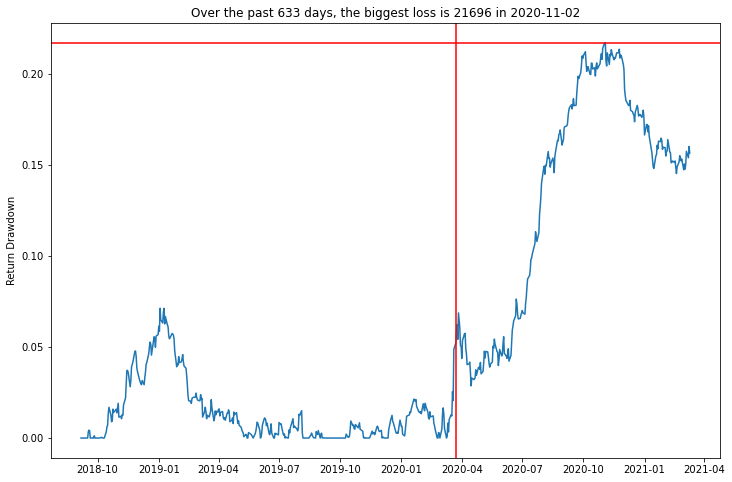

In [98]:
test.index = pd.to_datetime(test.index)
temp = test.copy()
temp.resample('M').mean()
plt.figure(figsize = (12,8))
plt.plot(test.index,test["DrawnDown"])
plt.axhline(test.loc[test["DrawnDown"].idxmax(),"DrawnDown"], color = "r")
plt.axvline(x ='2020-03-23', color = "r")
plt.ylabel("Return Drawdown")
plt.title("Over the past {} days, the biggest loss is {} in {}".format(test.shape[0],round(Max_Drawndown),test["DrawnDown"].idxmax()\
                                  .strftime("%Y-%m-%d")))
plt.show()

<AxesSubplot:xlabel='Date'>

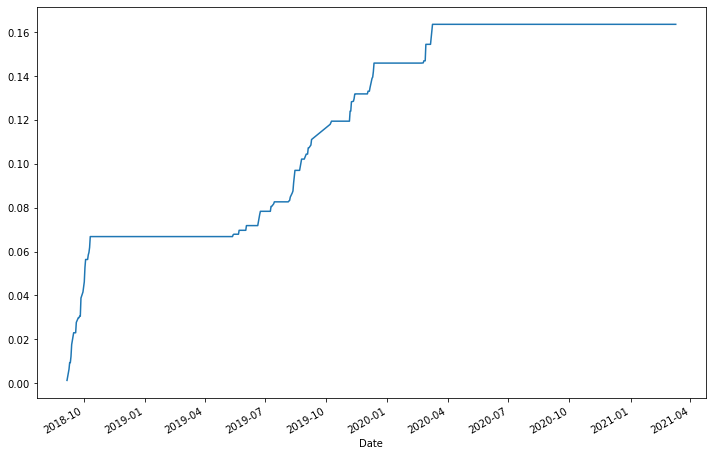

In [99]:
plt.figure(figsize = (12,8))
test["Cum_Max"].plot()

### Cumulative Return
累計報酬

No handles with labels found to put in legend.


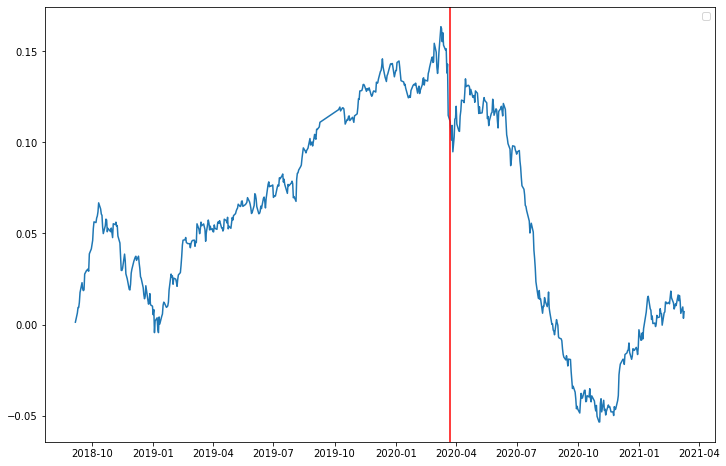

In [100]:
plt.figure(figsize = (12,8))
plt.plot(test.index,test["Cum_Return"])
plt.axvline(x ='2020-03-23', color = "r")
plt.legend()

### VaR with different Confidences
不同信心水準下的VaR

In [101]:
percs = [0.01, 0.1, 1., 2.5, 5.0, 10.0]
confidence = pd.Series(100 - np.array(percs))
VaR = pd.Series(scs.scoreatpercentile(lotsize * abs(test['Return'])*test["Accuracy"], percs))
t = pd.DataFrame()
g = pd.concat([t,VaR,confidence], axis = 1 )
g.columns = ["VaR", "Confidence Level%"]
Result["VaR with {} Confidence".format(g["Confidence Level%"].iloc[0])] = round(g["VaR"].iloc[0])
g

,VaR,Confidence Level%
0,-2727.971526,99.99
1,-1950.042561,99.90
2,-899.197897,99.00
3,-740.154838,97.50
4,-640.016878,95.00
5,-489.644944,90.00


In [102]:
pd.DataFrame(Result, index = [0]).T.rename(columns = {0:"Values(USD)"})

,Values(USD)
Predicted Return,709
Expected Return,2626
Expected Loss,46634
Max Drawdown in 633 days,21696
VaR with 99.99 Confidence,-2728
